# Data analysis for SPT data

In [1]:
from ipywidgets import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from module.preprocessing import preprocessing, get_groundtruth_with_label
from module.fileIO.DataLoad import read_multiple_csv, read_multiple_h5s

# Option settings for data analysis.

In [2]:
PIXELMICRONS = 0.16
FRAMERATE = 0.01
CUTOFF = 5
FOLDER = 'condition2'
number_of_bins = 50
figure_resolution_in_dpi = 200
figure_font_size = 20

In [15]:
def curve(time, k, alpha):
    return k * time**alpha * 4

# preprocessing generates 7 data.
### @params: data folder path, pixel microns, frame rate, cutoff
### @output: DataFrame, DataFrame, ndarray, networkx grpah, DataFrame, DataFrame, list

# preprocessing includes below steps.
### 1. exclude the trajectory where length is shorter than CUTOFF
### 2. convert from pixel unit to micrometer unit with PIXELMICRONS and FRAMERATE
### 3. generate 4 DataFrames, 1 ndarray representation of markovchain, 1 graph respresentation of markovchain, 1 list containing states

In [4]:
original_data = read_multiple_h5s(path=FOLDER)
analysis_data1, analysis_data2, state_markov, state_graph, msd, tamsd, states = preprocessing(data=original_data, pixelmicrons=PIXELMICRONS, framerate=FRAMERATE, cutoff=CUTOFF)
#analysis_data1, analysis_data2, state_markov, state_graph, msd, tamsd, states = get_groundtruth_with_label(data=original_data, label_folder='dummy', pixelmicrons=PIXELMICRONS, framerate=FRAMERATE, cutoff=CUTOFF)

** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|█████████████████████████████████████████████████████████████| 1192/1192 [02:57<00:00,  6.70trajectory/s]


** preprocessing finished **


From here, we treat data to make plots or print results.<br>
Data is stored as<br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, log10_K, alpha, state, duration, traj_id)<br>
2. analysis_data2: (DataFrame: contains data of displacments, state)<br>
3. state_markov: (matrix: contains transition probability)<br>
4. state_graph: (network: built from transitions between states(weight: nb of occurence of transitions))<br>
5. msd: (DataFrame: contains msd for each state.) <br>
6. tamsd: (DataFrame: contains ensemble-averaged tamsd for each state.) <br>
-> ref: https://www.researchgate.net/publication/352833354_Characterising_stochastic_motion_in_heterogeneous_media_driven_by_coloured_non-Gaussian_noise<br>
-> ref: https://arxiv.org/pdf/1205.2100<br>
7. states: classified states beforehand with BI-ADD or other tools.<br>

Units: <br>
log10_K: generalized diffusion coefficient in log10, um^2/s^alpha.<br>
alpha: anomalous diffusion exponent, real number between 0 and 2.<br>
mean_jump_disatnce: set of averages of jump distances in um.<br>
state: states defined in BI-ADD.<br>
duration: duration of trajectory in seconds.<br>
displacement: displacement(time lag=1) of all trajectories in um.<br>

In [5]:
print(f'\nanalysis_data1:\n', analysis_data1)
print(f'\nanalysis_data2:\n', analysis_data2)
print(f'\nMSD:\n', msd)
print(f'\nEnsemble-averaged TAMSD:\n', tamsd)


analysis_data1:
       mean_jump_d   log10_K    alpha  state  duration          traj_id
0        0.262688  0.468118  1.09153      0      0.44   trajs_fov_18_0
1        0.051946 -2.699107  0.22151      1      0.36   trajs_fov_18_1
2        0.277908  0.616124  1.12493      0      0.62   trajs_fov_18_2
3        0.049419 -3.020844  0.04395      1      1.38   trajs_fov_18_2
4        0.279790  0.825812  1.21858      0      0.17   trajs_fov_18_3
...           ...       ...      ...    ...       ...              ...
2094     0.044058 -3.065440  0.08553      1      1.93  trajs_fov_20_31
2095     0.305377  0.532604  1.02427      0      0.07  trajs_fov_20_32
2096     0.039505 -3.184483  0.07420      1      1.93  trajs_fov_20_32
2097     0.276362  0.525524  1.07077      0      0.84  trajs_fov_20_33
2098     0.082173 -2.372821  0.15787      1      1.16  trajs_fov_20_33

[2099 rows x 6 columns]

analysis_data2:
         displacements  state
0            0.071990      0
1            0.217073      0


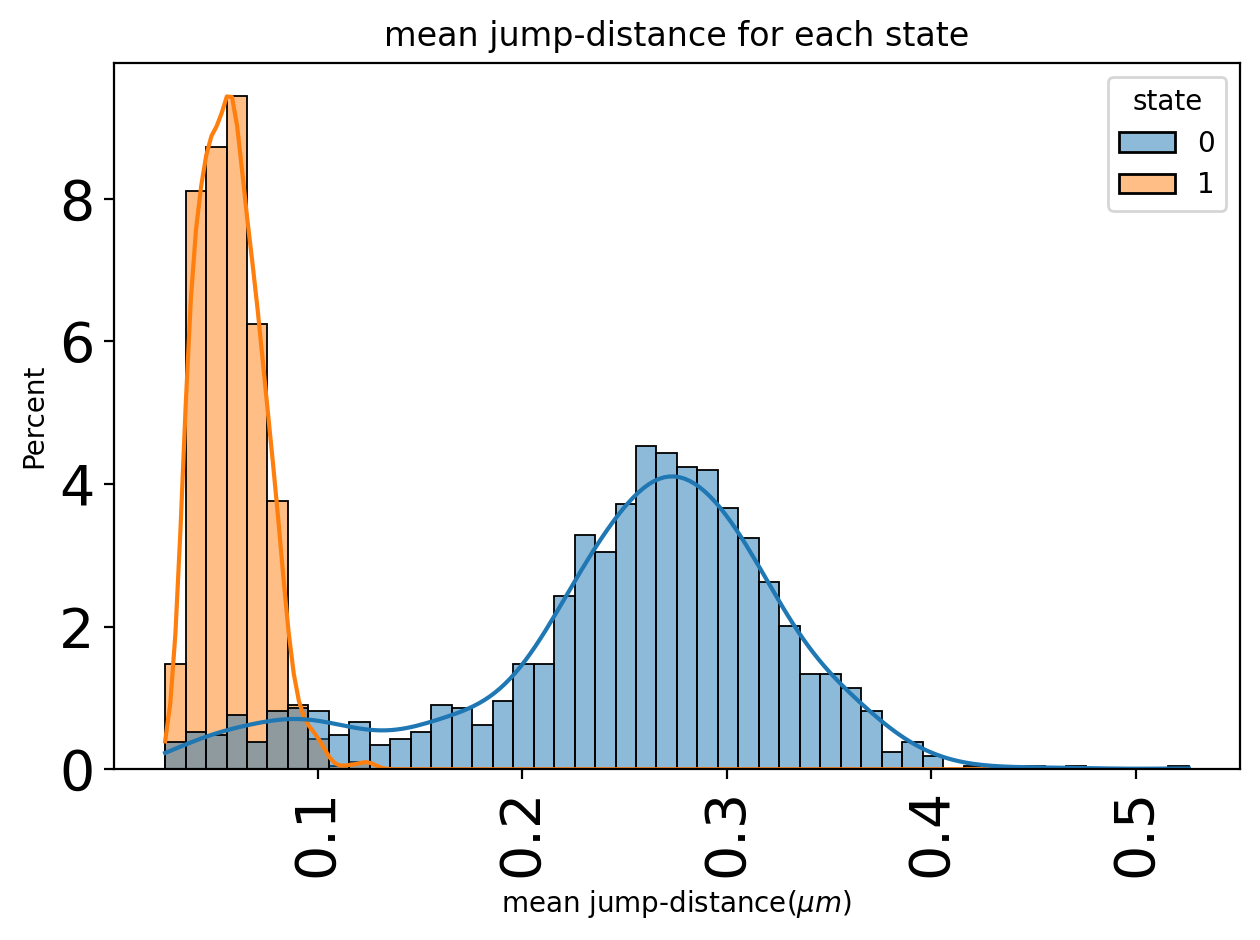

In [7]:
#p1: histogram with kde(kernel density estimation) plot of mean jump distance grouped by state.
plt.figure(f'p1', dpi=figure_resolution_in_dpi)
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', hue='state', bins=number_of_bins, kde=True)
p1.set_xlabel(r'mean jump-distance($\mu m$)')
p1.set_title(f'mean jump-distance for each state')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

/tmp/ipykernel_26863/4215179761.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p2.ax_joint.set_yticklabels(p2.ax_joint.get_yticks(), fontsize = figure_font_size)
/tmp/ipykernel_26863/4215179761.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  p2.ax_joint.set_xticklabels(p2.ax_joint.get_xticks(), fontsize = figure_font_size)


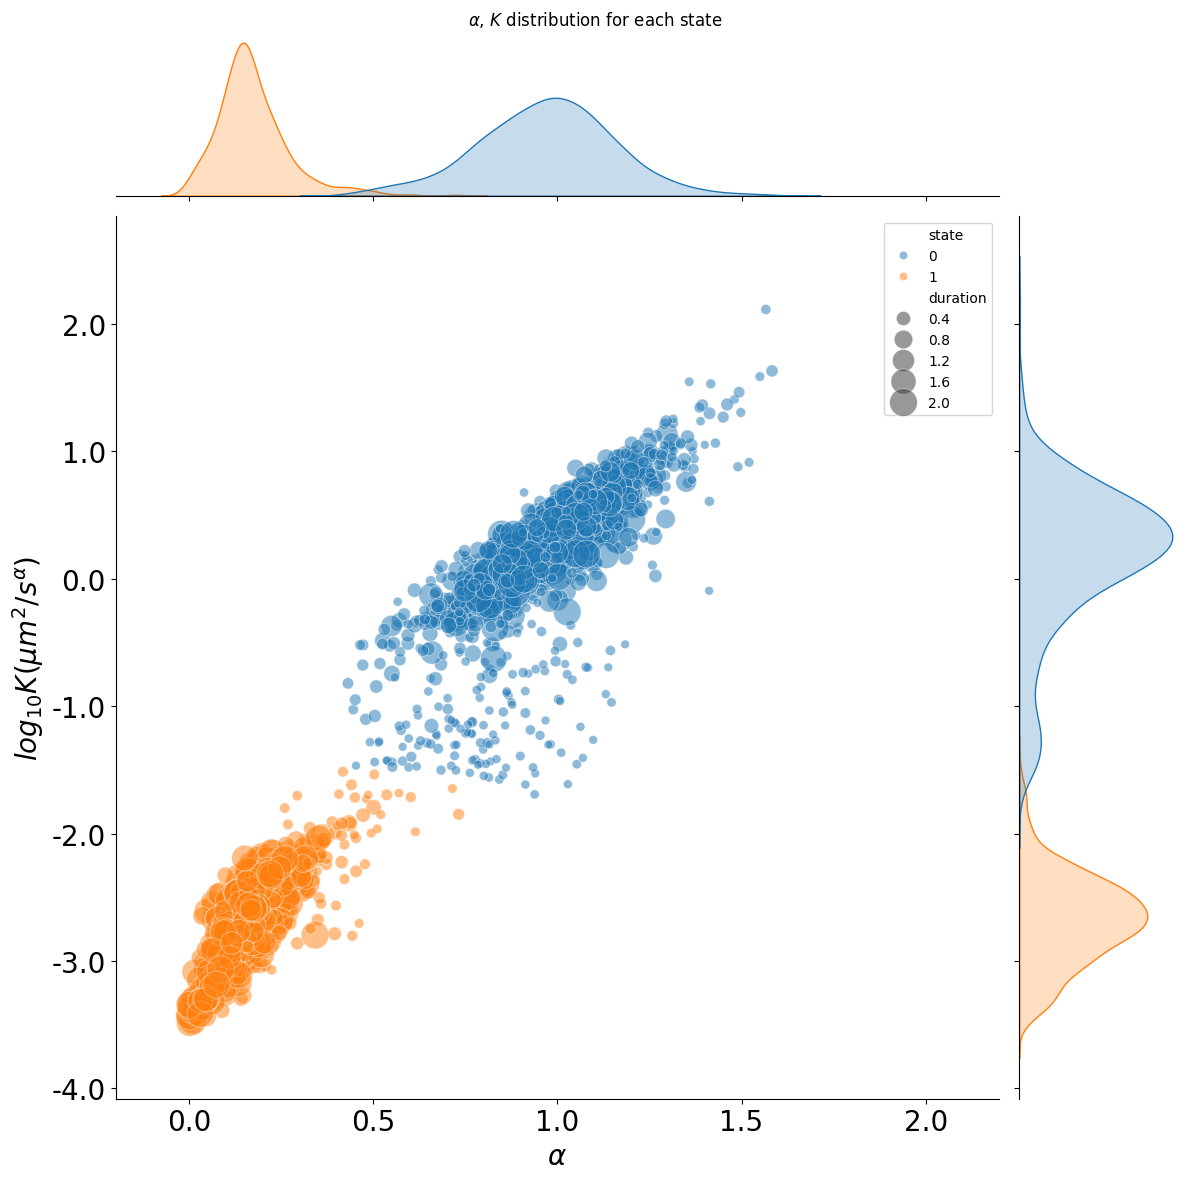

In [8]:
#p2: joint distribution plot of alpha(x-axis) and K(y-axis) for each state
p2 = sns.jointplot(data=analysis_data1, x=f'alpha', y=f'log10_K', kind='scatter', hue='state', height=12, xlim=(-0.2, 2.2), 
                   joint_kws={'data':analysis_data1, 'size':'duration', 'sizes':(40, 400), 'alpha':0.5})
p2.set_axis_labels(xlabel=r'$\alpha$', ylabel=r'$log_{10}K(\mu m^2/s^\alpha)$', fontsize=figure_font_size)
p2.figure.suptitle(r'$\alpha$, $K$ distribution for each state')
p2.ax_joint.set_yticklabels(p2.ax_joint.get_yticks(), fontsize = figure_font_size)
p2.ax_joint.set_xticklabels(p2.ax_joint.get_xticks(), fontsize = figure_font_size)
plt.tight_layout()

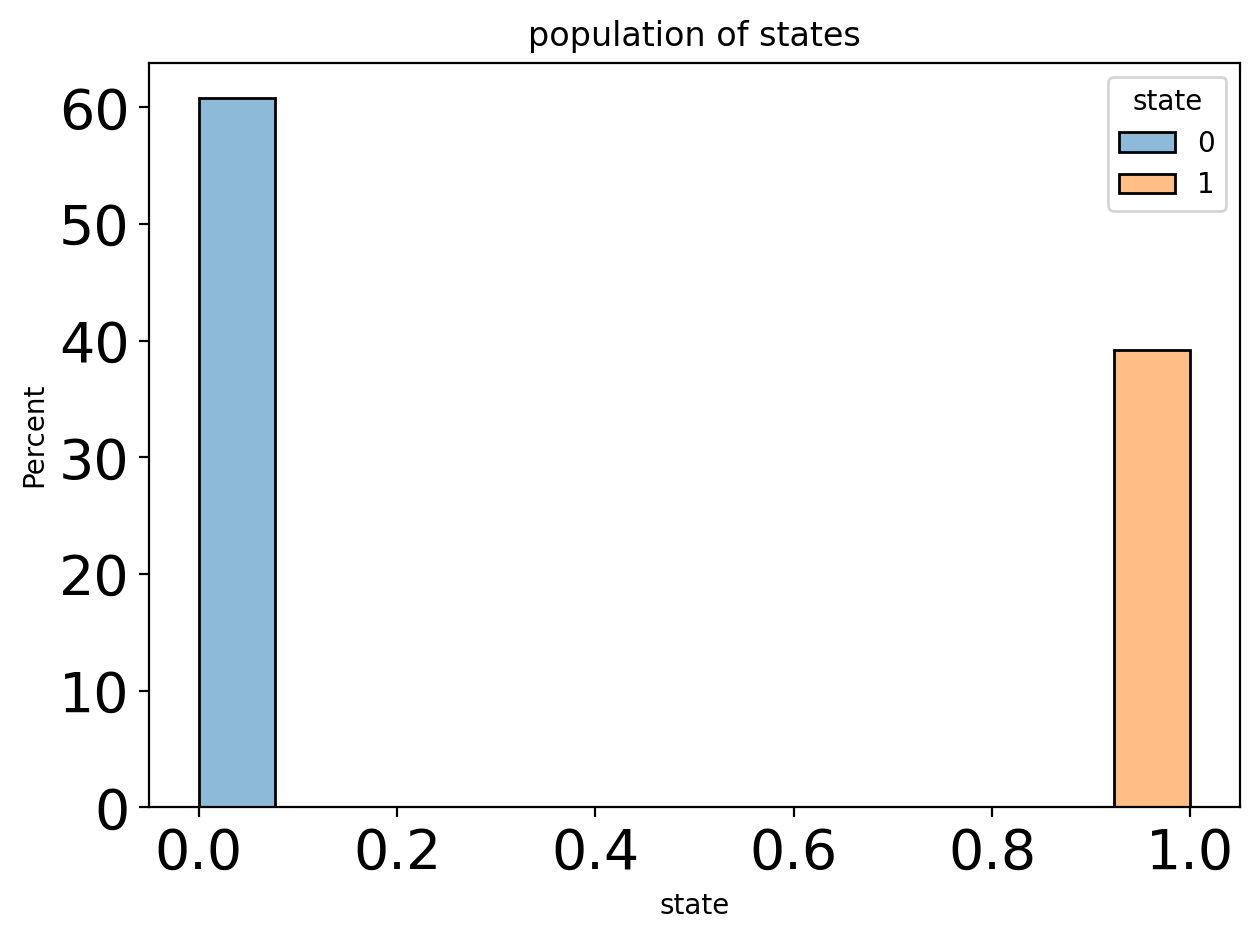

In [9]:
#p3: histogram of states
plt.figure(f'p3', dpi=figure_resolution_in_dpi)
p3 = sns.histplot(data=analysis_data1, x="state", stat='percent', hue='state')
p3.set_title(f'population of states')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.tight_layout()

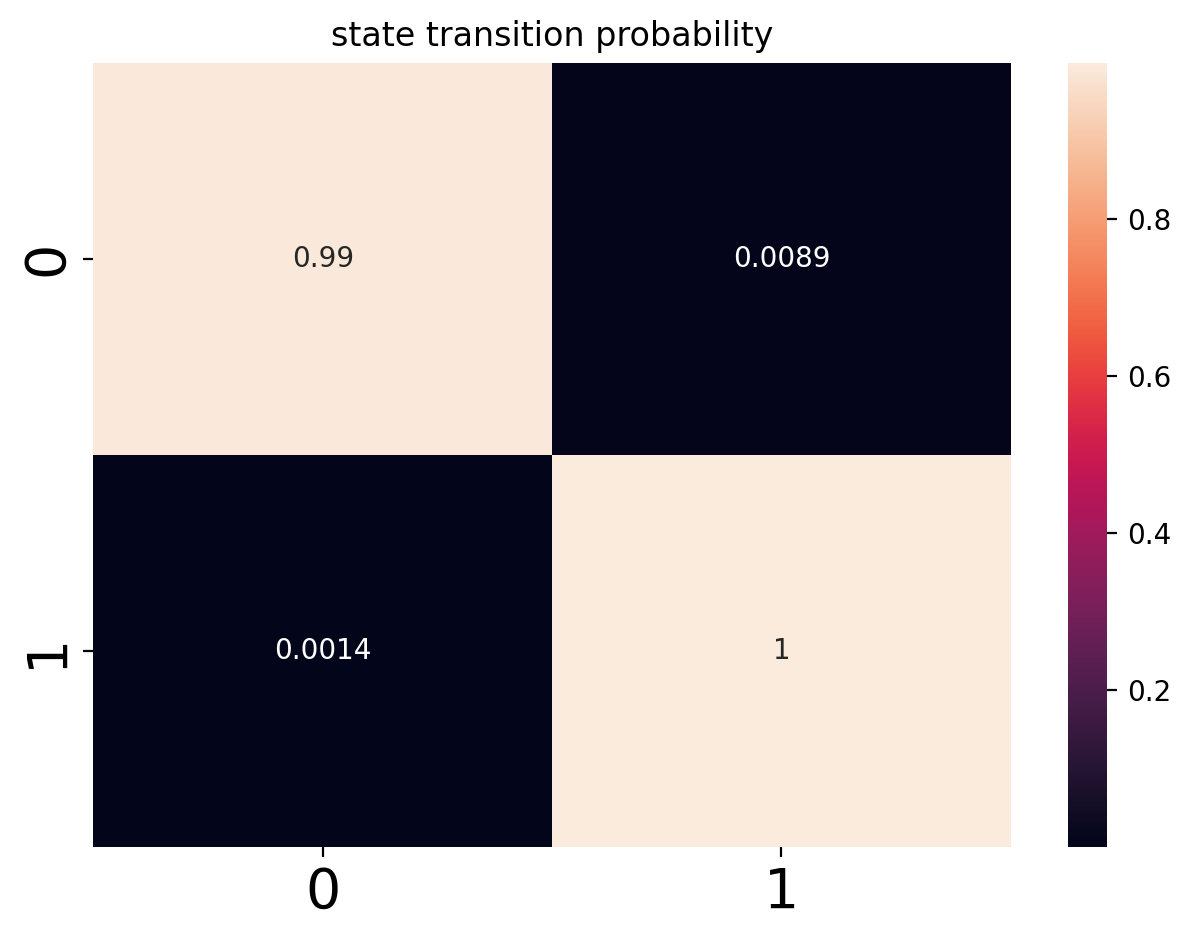

In [10]:
#p4: state transition probability
plt.figure(f'p4', dpi=figure_resolution_in_dpi)
p4 = sns.heatmap(state_markov, annot=True)
p4.set_title(f'state transition probability')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.tight_layout()

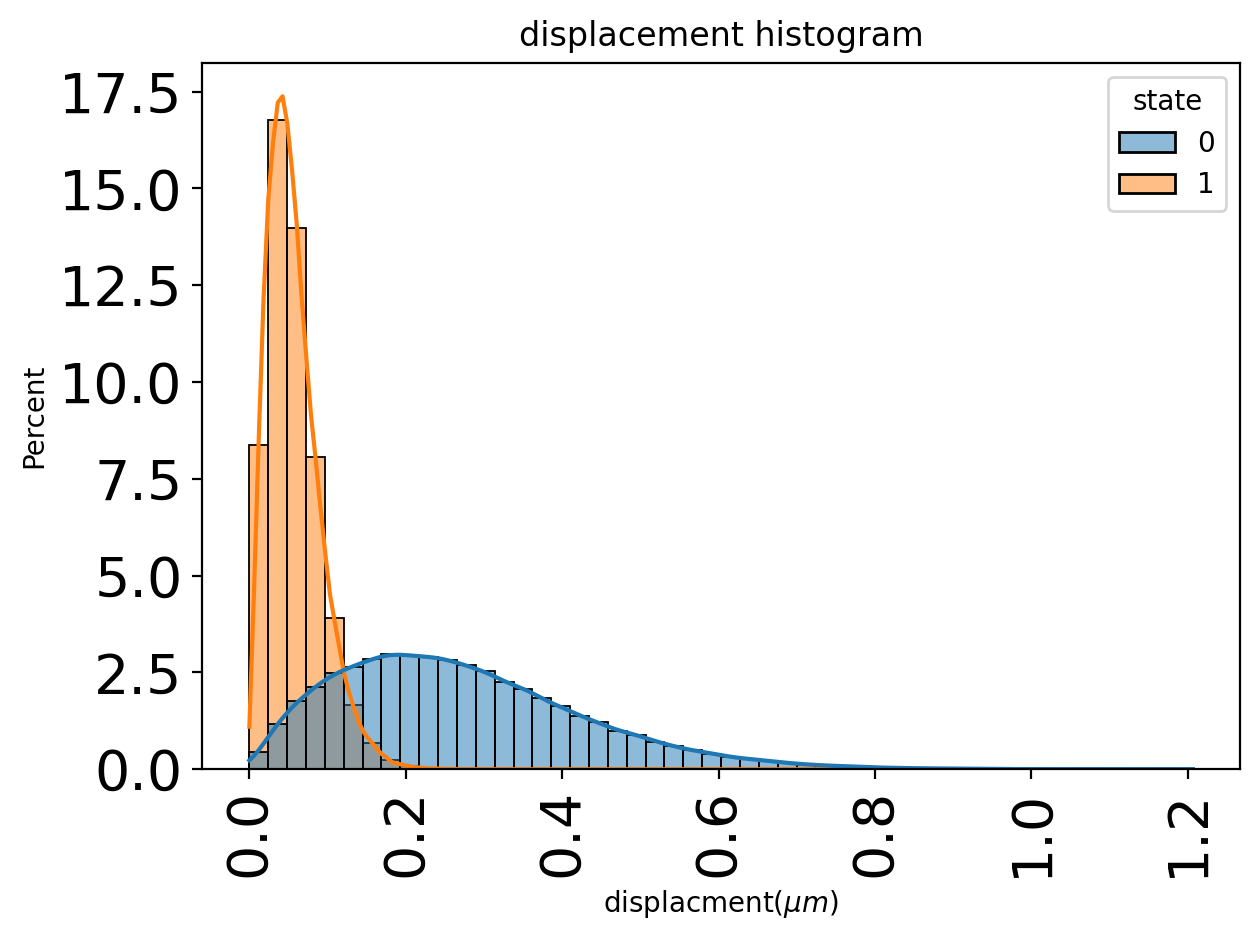

In [25]:
#p5: displacement histogram
plt.figure(f'p5', dpi=figure_resolution_in_dpi)
p5 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', hue='state', bins=number_of_bins, kde=True)
p5.set_title(f'displacement histogram')
p5.set_xlabel(r'displacment($\mu m$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

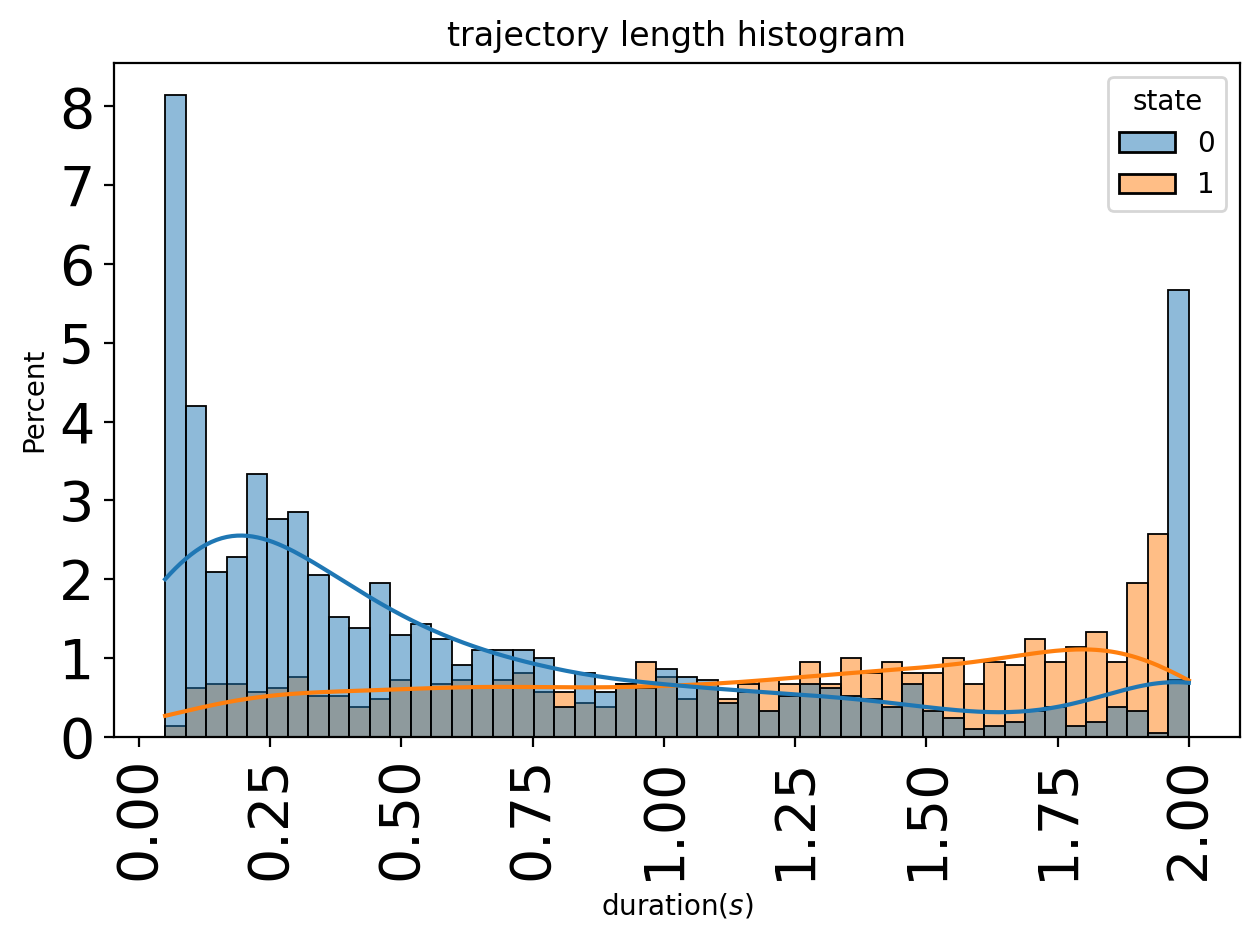

In [12]:
#p6: trajectory length(sec) histogram
plt.figure(f'p6', dpi=figure_resolution_in_dpi)
p6 = sns.histplot(data=analysis_data1, x='duration', stat='percent', hue='state', bins=number_of_bins, kde=True)
p6.set_title(f'trajectory length histogram')
p6.set_xlabel(r'duration($s$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

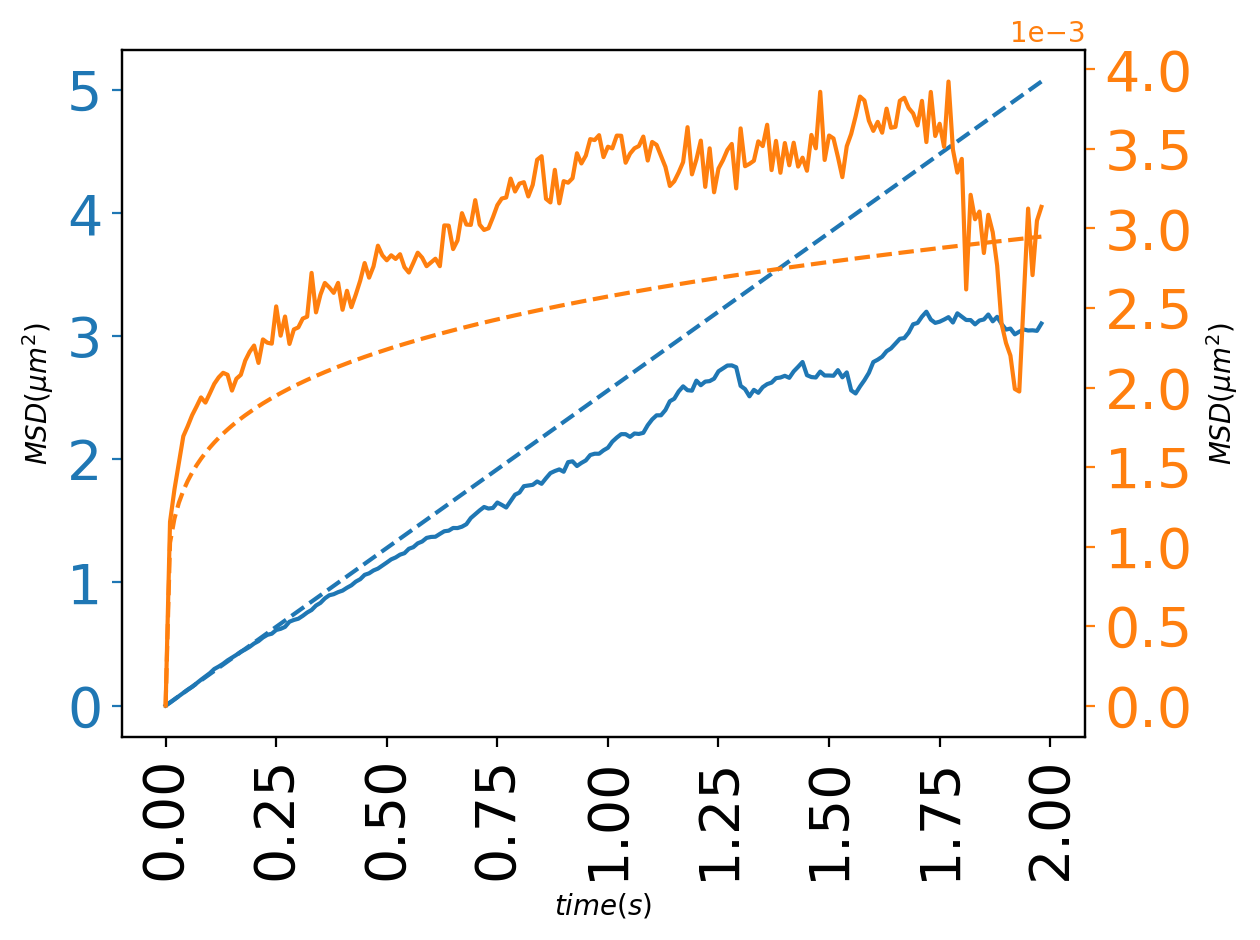

In [22]:
#p7: MSD
plt.figure(f'p7', dpi=figure_resolution_in_dpi)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,1))
p7 = sns.lineplot(data=msd, x=msd['time'][msd['state']==0], y=msd['mean'][msd['state']==0], c='C0')
p7.set_xlabel(r'$time(s)$')
p7.set_ylabel(r'$MSD(\mu m^2)$')
p7.plot(msd['time'][msd['state']==0], curve(msd['time'][msd['state']==0], 1 * ((PIXELMICRONS**2)/FRAMERATE), 1) / 4, linestyle='dashed', c='C0')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size, rotation=90)
p7_ax2= p7.twinx()
plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,1))
sns.lineplot(data=msd, x=msd['time'][msd['state']==1], y=msd['mean'][msd['state']==1], c='C1', ax=p7_ax2)
p7_ax2.plot(msd['time'][msd['state']==1], curve(msd['time'][msd['state']==1], 0.01 * ((PIXELMICRONS**2)/FRAMERATE**0.2), 0.2), linestyle='dashed', c='C1')
plt.yticks(fontsize=figure_font_size)
p7.tick_params(axis='y', colors='C0')
p7_ax2.tick_params(axis='y', colors='C1')
p7_ax2.set_ylabel(r'$MSD(\mu m^2)$')
#p7.set_title(f'MSD')
plt.xticks(fontsize=figure_font_size)
for state_idx, state in enumerate(states):
    # lower, upper bound related to the number of data (TODO: testing now)
    msd_per_state = msd[msd['state'] == state].sort_values('time')
    mus = msd_per_state['mean']
    sigmas = msd_per_state['std']
    lower_bound = [mu - sigma for mu, sigma in zip(mus, sigmas)]
    upper_bound = [mu + sigma for mu, sigma in zip(mus, sigmas)]
    #plt.fill_between(msd_per_state['time'], lower_bound, upper_bound, alpha=.3, color=f'C{state_idx}')
plt.tight_layout()
plt.show()

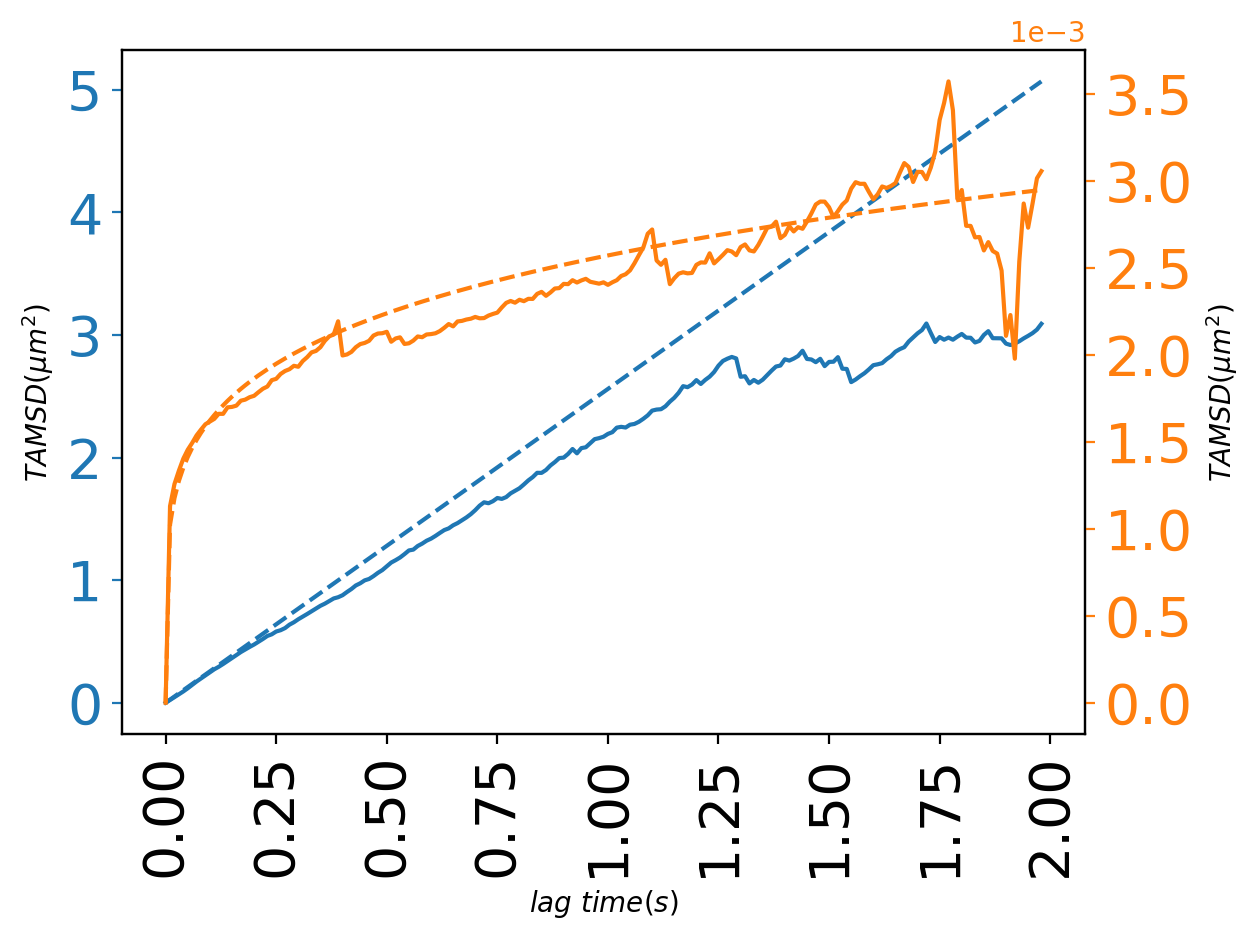

In [23]:
#p8: Ensemble-averaged TAMSD
plt.figure(f'p8', dpi=figure_resolution_in_dpi)
plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,1))
p8 = sns.lineplot(data=tamsd, x=tamsd['time'][tamsd['state']==0], y=tamsd['mean'][tamsd['state']==0], c='C0')
p8.plot(tamsd['time'][tamsd['state']==0], curve(tamsd['time'][tamsd['state']==0], 1 * ((PIXELMICRONS**2)/FRAMERATE), 1) / 4, linestyle='dashed', c='C0')
p8.set_xlabel(r'$lag\ time(s)$')
p8.set_ylabel(r'$TAMSD(\mu m^2)$')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size, rotation=90)
p8_ax2= p8.twinx()
plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,1))
sns.lineplot(data=tamsd, x=tamsd['time'][tamsd['state']==1], y=tamsd['mean'][tamsd['state']==1], c='C1', ax=p8_ax2)
p8_ax2.plot(tamsd['time'][tamsd['state']==1], curve(tamsd['time'][tamsd['state']==1], 0.01 * ((PIXELMICRONS**2)/FRAMERATE**0.2), 0.2), linestyle='dashed', c='C1')
plt.yticks(fontsize=figure_font_size)
p8.tick_params(axis='y', colors='C0')
p8_ax2.tick_params(axis='y', colors='C1')
p8_ax2.set_ylabel(r'$TAMSD(\mu m^2)$')
#p8.set_title(f'Ensemble-averaged TAMSD')
plt.xticks(fontsize=figure_font_size)

for state_idx, state in enumerate(states):
    # lower, upper bound related to the number of data (TODO: testing now)
    tamsd_per_state = tamsd[tamsd['state'] == state].sort_values('time')
    mus = tamsd_per_state['mean']
    sigmas = tamsd_per_state['std']
    lower_bound = [mu - sigma for mu, sigma in zip(mus, sigmas)]
    upper_bound = [mu + sigma for mu, sigma in zip(mus, sigmas)]
    #plt.fill_between(tamsd_per_state['time'], lower_bound, upper_bound, alpha=.3, color=f'C{state_idx}')
plt.tight_layout()
plt.show()